# ModelV2
Improves of V1 by taking G-Buffers as input and G-buffer feature extractor.

In [1]:
import os
# Display current working directory
print(os.getcwd())
# To make sure opencv imports .exr files
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
# If the current directory is not WDSS, then set it to one level up
if os.getcwd()[-4:] != 'WDSS':
    os.chdir('..')
print(os.getcwd())

c:\Dev\MinorProject\WDSS\jupyter_notebooks
c:\Dev\MinorProject\WDSS


## Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from config import Settings, device
from network.modules.feature_extractors import HRGBufferFeatureExtractor, LRFrameFeatureExtractor
from network.modules.reconstruction_modules import FeatureFusion
from utils.image_utils import ImageUtils
from network.dataset import WDSSDatasetCompressed, GB_Type

from typing import List, Tuple, Union

# Model

In [3]:
class WDSSV2(nn.Module):
    def __init__(self):
        super(WDSSV2, self).__init__()

        self.upscale_factor = 2
        self.hr_gbuffer_feature_extractor = HRGBufferFeatureExtractor(48, 32, [64, 64, 64, 64])
        self.lr_frame_feature_extractor = LRFrameFeatureExtractor(12, 32, [32, 32])
        self.feature_fusion = FeatureFusion(64, 12, [64, 48])

    def forward(self, lr_frame: torch.Tensor, hr_gbuffers: torch.Tensor) -> torch.Tensor:
        lr_frame_pixel_unshuffled = F.pixel_unshuffle(lr_frame, 2)
        hr_gbuffers_pixel_unshuffled = F.pixel_unshuffle(hr_gbuffers, 2)

        lr_frame_features = self.lr_frame_feature_extractor(lr_frame_pixel_unshuffled)
        # Upsample the low resolution frame features
        lr_frame_features_upsampled = F.interpolate(lr_frame_features, scale_factor=self.upscale_factor, mode='nearest')

        hr_gbuffers_features = self.hr_gbuffer_feature_extractor(hr_gbuffers_pixel_unshuffled)

        # Concatenate the features
        features = torch.cat((lr_frame_features_upsampled, hr_gbuffers_features), dim=1)

        # Fuse the features
        output_pre_pixel_shuffle = self.feature_fusion(features)

        # Pixel shuffle the output
        output = F.pixel_shuffle(output_pre_pixel_shuffle, 2)

        return output


# Dataset

In [5]:
dataset_folder = "D:\\Dev\\MinorProjDataset\\V2\\train"

dataset = WDSSDatasetCompressed(dataset_folder, 120)
print(len(dataset))

120


In [6]:
# Model
model = WDSSV2().to(device)

Batch 1, Loss: 0.0024863292928785086


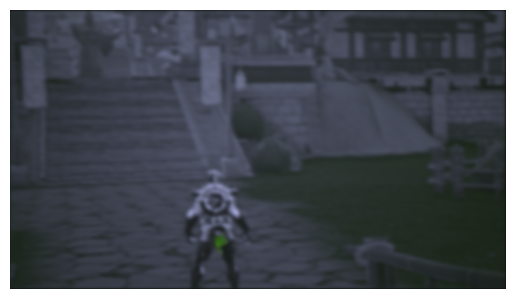

In [19]:
model.eval()
with torch.no_grad():
    res = model(dataset[0]['LR'].unsqueeze(0).to(device), dataset[0]['GB'].unsqueeze(0).to(device))
    ImageUtils.display_image(res.cpu())

In [18]:
# Training Loop
import threading

# Criterion
criterion = nn.MSELoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Dataloader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
epochs = 5
epoch_loss: float = 0

def do_nothing():
    ...

def train(i, batch):
    global epoch_loss
    lr_frames = batch['LR'].to(device)
    hr_gbuffers = batch['GB'].to(device)
    hr_frames = batch['HR'].to(device)

    optimizer.zero_grad()

    output = model(lr_frames, hr_gbuffers)
    loss = criterion(output, hr_frames)
    loss.backward()

    optimizer.step()

    epoch_loss += loss.item()
    print(f"Batch {i}, Loss: {loss.item()}")

threadu = threading.Thread(target=do_nothing)
threadu.start()

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for i, batch in enumerate(dataloader):
        # print("Data loading completed")

        # Wait for the previous batch to finish
        if threadu.is_alive():
            threadu.join()

        # print(f"Batch {i} started")

        # Start the training process
        threadu = threading.Thread(target=train, args=(i, batch))
        threadu.start()
    
    if threadu.is_alive():
        threadu.join()

    print(f"Epoch: {epoch}, Loss: {epoch_loss}")
    


Batch 0, Loss: 0.00533923227339983
Batch 1, Loss: 0.06356940418481827
Batch 2, Loss: 0.007061492186039686
Batch 3, Loss: 0.014818078838288784
Batch 4, Loss: 0.02423957549035549
Batch 5, Loss: 0.02817780151963234
Batch 6, Loss: 0.028651710599660873
Batch 7, Loss: 0.027734778821468353
Batch 8, Loss: 0.024006355553865433
Batch 9, Loss: 0.018960963934659958
Batch 10, Loss: 0.013917140662670135
Batch 11, Loss: 0.012632850557565689
Batch 12, Loss: 0.011087989434599876
Batch 13, Loss: 0.007778636645525694
Batch 14, Loss: 0.0066111828200519085
Epoch: 0, Loss: 0.2945871935226023
Batch 0, Loss: 0.005552678368985653
Batch 1, Loss: 0.00498085655272007
Batch 2, Loss: 0.005902183707803488
Batch 3, Loss: 0.0056351046077907085
Batch 4, Loss: 0.005793697666376829
Batch 5, Loss: 0.006088877096772194
Batch 6, Loss: 0.005847100634127855
Batch 7, Loss: 0.005163121502846479
Batch 8, Loss: 0.005144997034221888
Batch 9, Loss: 0.0043796272948384285
Batch 10, Loss: 0.004488623701035976
Batch 11, Loss: 0.0040700

KeyboardInterrupt: 

In [17]:
# Save the model
torch.save(model.state_dict(), "model/WDSSV2.pth")